# Capstone Project: Life in the "New Normal"
---

#### Organization of Project Notebooks:
- Notebook #1: [Problem Statement & Webscraping](./01_problem_statement_and_web_scraping.ipynb)
- Notebook #2: [Data Cleaning & Exploratory Data Analysis](./02_data_cleaning_and_eda.ipynb)
- **Notebook #3: Preprocessing & Modelling**
    - Notebook #3-1: [Preprocessing & Sentiment Analysis](./03-1_preprocessing_and_sentiment_analysis.ipynb)
    - **Notebook #3-2: Building Pre-trained LSTM RNN Model for Sentiment Analysis  (current notebook)**
- Notebook #4: [Topic Modelling & Conclusion](./04_topic_modelling_and_conclusion.ipynb)
- Notebook #5: [Plotly & Dash Visualization](./05_plotly_and_dash.ipynb)

## Notebook #3-2: Building Pre-trained LSTM RNN Model for Sentiment Analysis 

### Contents
1. [Introduction](#1.-Introduction)
2. [Preprocessing](#2.-Preprocessing)
3. [Creating a LSTM RNN model using Sentiment140 labelled tweets](#3.-Creating-a-LSTM-RNN-model-using-Sentiment140-labelled-tweets)
4. [Creating a LSTM RNN model using unlabelled Singapore tweets](#4.-Creating-a-LSTM-RNN-model-using-unlabelled-Singapore-tweets)

### 1. Introduction

In this section, I will be creating a reference Long Short-Term Memory (LSTM) Recurrent Neural Network (RNN) model for predicting the sentiment of the tweets in Singapore. To do so, I will be utilising labelled tweets from the Sentiment140 dataset which contains 1,600,000 tweets annotated with 'positive' (4) or 'negative' (0) sentiment (source: [Sentiment140, 2021](http://help.sentiment140.com/for-students)). 

A LSTM RNN model will be trained on the 500,000 labelled tweets, and used to predict the sentiment of Singapore tweets in the odd months of 2021 (January, March, May and July). Eventually, a new LSTM RNN model will be created using the Singapore tweets in the odd months of 2021 and their predicted sentiment labels, and employed in [this notebook](./03-1_preprocessing_and_sentiment_analysis.ipynb) to predict the sentiment of tweets in the even months of 2021 (February, April and June).

In [1]:
# import the relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

import nltk
from nltk.tokenize import word_tokenize      
from nltk.stem import WordNetLemmatizer                         
import re
from wordcloud import WordCloud

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

pd.set_option('display.max_columns', None)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

warnings.filterwarnings('ignore')

### 2. Preprocessing

To ensure that the method used for predicting the sentiment of the tweets is aligned, the same preprocessing steps (with reference to [this notebook](./02_data_cleaning_and_eda.ipynb) and [this notebook](./03-1_preprocessing_and_sentiment_analysis.ipynb)) are employed. This includes the removal of mention, hashtag, retweet info and URL from each tweet, and subsequently applying tokenization and lemmatization. Stop words will not be removed, as LSTM RNN takes into consideration the sequence of the words in a text to determine the sentiment. 

In [3]:
# import the dataframe
header_list = ['label', 'id', 'date', 'query', 'user', 'tweet']
labelled_tweets_df = pd.read_csv('../datasets/training_1600000_reference.csv', names=header_list, encoding='latin-1')

# view the top 5 rows
labelled_tweets_df.head()

,label,id,date,query,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
# view the split in the proportion of label
labelled_tweets_df['label'].value_counts()

4    800000
0    800000
Name: label, dtype: int64

In [5]:
# drop unnecessary columns
labelled_tweets_df = labelled_tweets_df.drop(columns=['id', 'date', 'query', 'user'])

In [6]:
# create a function to obtain the shape, no. of missing and duplicated values, and datatypes
def data_summary(df):

    # view the shape of the dataframe
    print(f'There are {df.shape[0]} rows and {df.shape[1]} columns in the Twitter DataFrame.')
    print()
    
    # check for duplicated rows
    print(f'There are {df[df.duplicated(keep=False)].shape[0]} duplicated rows.')
    print()
    
    # check for missing values
    print('Number of missing values:')
    print(df.isnull().sum())
    print()
    
    # view the datatypes
    print('Data types of columns:')
    print(df.dtypes)
    
# view the summary
data_summary(labelled_tweets_df)

There are 1600000 rows and 2 columns in the Twitter DataFrame.

There are 22917 duplicated rows.

Number of missing values:
label    0
tweet    0
dtype: int64

Data types of columns:
label     int64
tweet    object
dtype: object


In [7]:
# drop duplicated rows
labelled_tweets_df = labelled_tweets_df.drop_duplicates()

In [8]:
# map the label values - 0 = negative; 4 = positive
labelled_tweets_df['label'] = labelled_tweets_df['label'].map({0:'negative', 4:'positive'})

# view the split in the proportion of label after dropping duplicated rows
labelled_tweets_df['label'].value_counts()

positive    793506
negative    790185
Name: label, dtype: int64

Instead of using all 1,600,000 tweets, 500,000 tweets (which is 1.5 times more than the number of tweets in the Singapore tweets DataFrame) – split equally between positive and negative tweets – will be identified to improve the model processing speed.

In [9]:
# identify first 250,000 negative tweets
labelled_tweets_neg_df = labelled_tweets_df[labelled_tweets_df['label']=='negative'].iloc[0:250000]

# identify first 250,000 positive tweets
labelled_tweets_pos_df = labelled_tweets_df[labelled_tweets_df['label']=='positive'].iloc[0:250000]

# combine both dataframes into one
labelled_tweets_comb_df = pd.concat([labelled_tweets_neg_df, labelled_tweets_pos_df])

In [10]:
# create a function to remove the mention, hashtag, retweet info and url from each tweet
def clean_tweet_text(text):
    text = re.sub(r'@[^\s]+', '', text)                    # remove mention 
    text = re.sub(r'\B#\S+', '', text)                     # remove hashtag 
    text = re.sub(r'RT[\s]+', '', text)                    # remove retweet
    text = re.sub(r'http\S+', '', text)                    # remove url   
    text = re.sub('[^A-Za-z]+', ' ', text)                 # remove non-alphabet words
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)            # remove all single characters in the text
    text = text.lower()                                    # change to lower case
    return text

# apply the following line makes use of an apply function-- it will call clean_tweet_text on every element in the 'text' column
labelled_tweets_comb_df['cleaned_tweet'] = labelled_tweets_comb_df['tweet'].transform(clean_tweet_text)

In [11]:
# instantiate the lemmatizier
lemmatizer = WordNetLemmatizer()

# set up the lemmatizer
# leave stopwords in the corpus
lemmatized_tweets = []
for tweet in labelled_tweets_comb_df['cleaned_tweet']:
    word_tokens = word_tokenize(tweet)
    
    tweet = [lemmatizer.lemmatize(word) for word in word_tokens]
    lemmatized_tweets.append(' '.join(tweet))
    
# append the lemmatized tweets to the DataFrame
labelled_tweets_comb_df['lemmatized_tweet'] = lemmatized_tweets

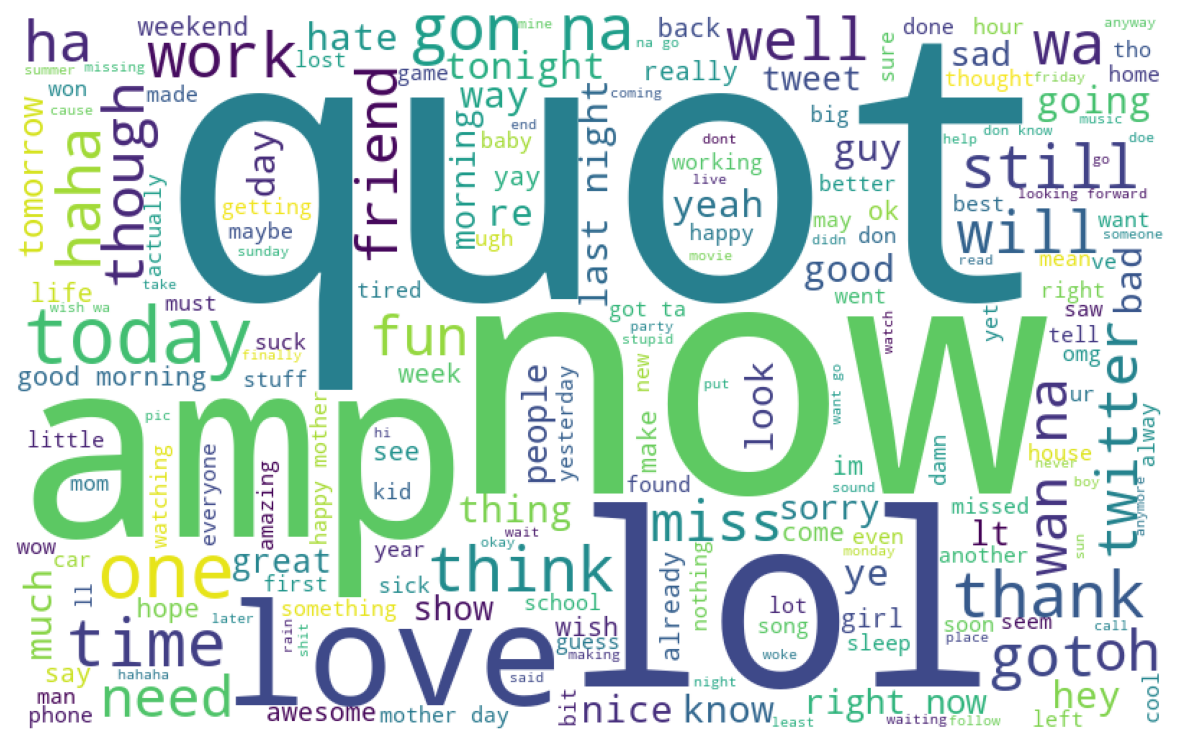

In [12]:
# convert the lemmatized_tweet into a list
labelled_tweets_list = labelled_tweets_comb_df['lemmatized_tweet'].tolist()

# create a wordcloud to visualize the top commonly ocurring words
temp_list = ' '.join(labelled_tweets_list)
wordcloud = WordCloud(width=800, height=500, 
                      background_color='white',
                      min_font_size=10).generate(temp_list)

plt.figure(figsize=(8,8))
plt.imshow(wordcloud) 
plt.axis("off")
plt.tight_layout(pad=0) 
  
plt.show('png')

From the word cloud, it is interesting to observe that some of the frequently occurring words include 'quot', 'now', 'amp', 'lol' and 'love', which are vastly different from the top occurring words among the Singapore tweets.

### 3. Creating a LSTM RNN model using Sentiment140 labelled tweets

To create a LSTM RNN model on the labelled tweets, I will need to first instantiate the tokenizer as part of Tensorflow's Keras' preprocessing text module, and add paddings to the tokenized words. Thereafter, the sentiment labels will need to be dummified before passing through the LSTM RNN model.

In [13]:
# instantiate tokenizer
tokenizer = Tokenizer()

# fit tokenizer on lemmatized tweet
tokenizer.fit_on_texts(labelled_tweets_comb_df['lemmatized_tweet'].values)

# assign X
X = tokenizer.texts_to_sequences(labelled_tweets_comb_df['lemmatized_tweet'].values)

# add pad_sequences to X
X = pad_sequences(X)

In [14]:
# map the label column to 0 for negative and 1 for positive 
labelled_tweets_comb_df['label_num'] = labelled_tweets_comb_df['label'].map(lambda x:1 if x=='positive' else 0)

# dummify the label column 
y = pd.get_dummies(labelled_tweets_comb_df['label_num'])

In [15]:
# instantiate LSTM 
vocab_size = len(tokenizer.word_counts)
embed_dim = 128
lstm_out = 196

# set up the model 
model = Sequential()
model.add(Embedding(vocab_size+1, embed_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# view model summary 
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 128)           15573632  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 40, 128)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 196)               254800    
_________________________________________________________________
dense (Dense)                (None, 2)                 394       
Total params: 15,828,826
Trainable params: 15,828,826
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [17]:
# fit the model
history = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=32, verbose='auto')

Epoch 1/5
10938/10938 [==============================] - 5974s 546ms/step - loss: 0.4510 - accuracy: 0.7865 - val_loss: 0.4183 - val_accuracy: 0.8073
Epoch 2/5
10938/10938 [==============================] - 5958s 545ms/step - loss: 0.3897 - accuracy: 0.8243 - val_loss: 0.4125 - val_accuracy: 0.8123
Epoch 3/5
10938/10938 [==============================] - 6069s 555ms/step - loss: 0.3490 - accuracy: 0.8467 - val_loss: 0.4256 - val_accuracy: 0.8091
Epoch 4/5
10938/10938 [==============================] - 7529s 688ms/step - loss: 0.3143 - accuracy: 0.8651 - val_loss: 0.4396 - val_accuracy: 0.8051
Epoch 5/5
10938/10938 [==============================] - 6563s 600ms/step - loss: 0.2863 - accuracy: 0.8780 - val_loss: 0.4710 - val_accuracy: 0.7956


In [19]:
# evaluate the model
model.evaluate(X_test, y_test)

4688/4688 [==============================] - 279s 59ms/step - loss: 0.4710 - accuracy: 0.7956


[0.4710218608379364, 0.7956200242042542]

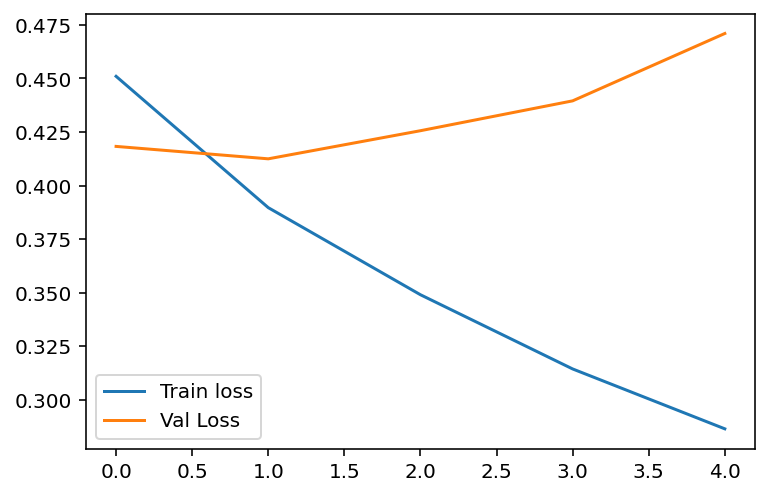

In [20]:
# plot the loss
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend();

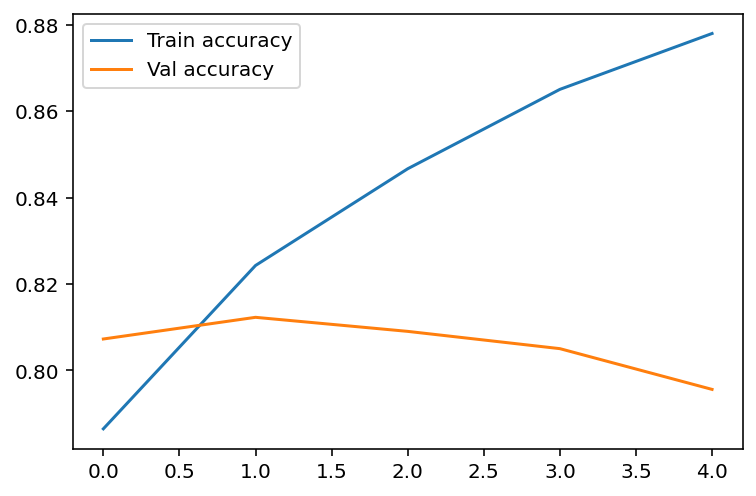

In [21]:
# plot the accuracy
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Val accuracy')
plt.legend();

When the model is applied on the test data of the labelled tweets from Sentiment140, the model achieves an accuracy of 79.6%. This is an improvement from a model created previously with 400,000 labelled tweets, which has an accuracy score of 75.7%.

Let's save the model as a separate file that can be used in subsequent notebooks.

In [22]:
# save model to single file
model.save('../models/lstm_wso_model.h5')

### 4. Creating a LSTM RNN model using unlabelled Singapore tweets

With the LSTM RNN model created, I will be adopting a semi-supervised learning approach, where I will first utilise the created model to predict the score for Singapore tweets in the odd months of 2021 (January (1), March (3), May (5) and July (7)).

Thereafter, I will create a new LSTM model based on the predicted sentiment labels obtained over the four months, and eventually use it in the prediction of the sentiment labels for tweets in the even months of 2021 (February (2), April (4) and June (6)).

### 4.1 Predicting sentiment labels for Singapore tweets in the odd months

In [24]:
# import the dataframe
sg_tweets_cleaned_lem_df = pd.read_csv('../datasets/sg_tweets_cleaned_lem_wso_2021.csv')

In [25]:
# view the top 5 rows
sg_tweets_cleaned_lem_df.head()

,id,date,tweet,language,hashtags,user_id,username,nlikes,nreplies,nretweets,near,date_only,month,year,hour,char_length,word_count,num_hashtag,num_mentions,cleaned_tweet,lemmatized_tweet
0,1355666922210164738,2021-01-31 07:59:15,@zettodot Haha! I know who you feel!,en,[],1269471373912535040,AuraGuardians2,1,0,0,Singapore,2021-01-31,1,2021,7,36,7,0,1,haha know who you feel,haha know who you feel
1,1355666319224397824,2021-01-31 07:56:52,Trained and smashed the pads and bags so hard ...,en,[],2252140291,EfashaKamarudin,1,0,0,Singapore,2021-01-31,1,2021,7,143,25,0,0,trained and smashed the pads and bags so hard ...,trained and smashed the pad and bag so hard ye...
2,1355665910283948036,2021-01-31 07:55:14,@zettodot I checking with you all. Excalty lev...,en,[],1269471373912535040,AuraGuardians2,1,1,0,Singapore,2021-01-31,1,2021,7,80,16,0,1,checking with you all excalty level to max al...,checking with you all excalty level to max als...
3,1355664963931570178,2021-01-31 07:51:29,Breakfast https://t.co/gN80tfjySA,en,[],971573083483004929,nenipuspitasar_,1,0,0,Singapore,2021-01-31,1,2021,7,34,2,0,0,breakfast,breakfast
4,1355664076957880320,2021-01-31 07:47:57,@zettodot Don't give up until the event end!,en,[],1269471373912535040,AuraGuardians2,1,0,0,Singapore,2021-01-31,1,2021,7,44,8,0,1,don give up until the event end,don give up until the event end


In [26]:
# extract only tweets in Jan, Mar, May, Jul 
sg_tweets_odd_df = sg_tweets_cleaned_lem_df[sg_tweets_cleaned_lem_df['month'].isin([1,3,5,7])]

In [27]:
# view the shape of the dataframe
print(f'There are {sg_tweets_odd_df.shape[0]} rows and {sg_tweets_odd_df.shape[1]} columns in the DataFrame.')

There are 183678 rows and 21 columns in the DataFrame.


In [28]:
# assign tweets to X 
X = sg_tweets_odd_df['lemmatized_tweet'].astype(str)

# assign X
X = tokenizer.texts_to_sequences(X.values)

# add pad_sequences to X
X = pad_sequences(X)

In [29]:
# apply model to X to predict y classes
y_odd = model.predict_classes(X)

In [30]:
# to add the classes to the dataframe
sg_tweets_odd_df['lstm_label'] = y_odd

# view top 5 rows
sg_tweets_odd_df.head()

,id,date,tweet,language,hashtags,user_id,username,nlikes,nreplies,nretweets,near,date_only,month,year,hour,char_length,word_count,num_hashtag,num_mentions,cleaned_tweet,lemmatized_tweet,lstm_label
0,1355666922210164738,2021-01-31 07:59:15,@zettodot Haha! I know who you feel!,en,[],1269471373912535040,AuraGuardians2,1,0,0,Singapore,2021-01-31,1,2021,7,36,7,0,1,haha know who you feel,haha know who you feel,1
1,1355666319224397824,2021-01-31 07:56:52,Trained and smashed the pads and bags so hard ...,en,[],2252140291,EfashaKamarudin,1,0,0,Singapore,2021-01-31,1,2021,7,143,25,0,0,trained and smashed the pads and bags so hard ...,trained and smashed the pad and bag so hard ye...,0
2,1355665910283948036,2021-01-31 07:55:14,@zettodot I checking with you all. Excalty lev...,en,[],1269471373912535040,AuraGuardians2,1,1,0,Singapore,2021-01-31,1,2021,7,80,16,0,1,checking with you all excalty level to max al...,checking with you all excalty level to max als...,1
3,1355664963931570178,2021-01-31 07:51:29,Breakfast https://t.co/gN80tfjySA,en,[],971573083483004929,nenipuspitasar_,1,0,0,Singapore,2021-01-31,1,2021,7,34,2,0,0,breakfast,breakfast,1
4,1355664076957880320,2021-01-31 07:47:57,@zettodot Don't give up until the event end!,en,[],1269471373912535040,AuraGuardians2,1,0,0,Singapore,2021-01-31,1,2021,7,44,8,0,1,don give up until the event end,don give up until the event end,0


In [31]:
# view the split of the labels
sg_tweets_odd_df['lstm_label'].value_counts()

1    119792
0     63886
Name: lstm_label, dtype: int64

It is interesting to note that the LSTM RNN model has predicted that the Singapore tweets in the odd months contain 119,792 tweets with positive sentiment labels and 63,886 tweets with negative sentiment labels.

Let's save the results for the odd months as a CSV file first. 

In [32]:
# output the file
sg_tweets_odd_df.to_csv('../datasets/sg_tweets_odd_wso_lstm_2021.csv', index=False)

### 4.2 Creating a LSTM RNN model using predicted labels for Singapore tweets in the odd months

With the predicted sentiment labels, let's now create a LSTM RNN model from the Singapore tweets in the odd months of 2021 (January (1), March (3), May (5) and July (7)).

In [33]:
# instantiate tokenizer
tokenizer = Tokenizer()

# fit tokenizer on lemmatized tweet
tokenizer.fit_on_texts(sg_tweets_odd_df['lemmatized_tweet'].astype(str).values)

# assign X
X = tokenizer.texts_to_sequences(sg_tweets_odd_df['lemmatized_tweet'].astype(str).values)

# add pad_sequences to X
X = pad_sequences(X)

In [34]:
# dummify the label column 
y = pd.get_dummies(sg_tweets_odd_df['lstm_label'])

In [35]:
# instantiate LSTM 
vocab_size = len(tokenizer.word_counts)
embed_dim = 128
lstm_out = 196

# set up the model 
model = Sequential()
model.add(Embedding(vocab_size+1, embed_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# view model summary 
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 60, 128)           7957248   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 60, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 394       
Total params: 8,212,442
Trainable params: 8,212,442
Non-trainable params: 0
_________________________________________________________________
None


In [36]:
# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [37]:
# fit the model
history_sg = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=32, verbose='auto')

Epoch 1/5
4018/4018 [==============================] - 3014s 747ms/step - loss: 0.4041 - accuracy: 0.8088 - val_loss: 0.3389 - val_accuracy: 0.8436
Epoch 2/5
4018/4018 [==============================] - 2572s 640ms/step - loss: 0.2688 - accuracy: 0.8830 - val_loss: 0.3180 - val_accuracy: 0.8580
Epoch 3/5
4018/4018 [==============================] - 1593s 396ms/step - loss: 0.1922 - accuracy: 0.9199 - val_loss: 0.3260 - val_accuracy: 0.8656
Epoch 4/5
4018/4018 [==============================] - 1926s 479ms/step - loss: 0.1424 - accuracy: 0.9429 - val_loss: 0.3430 - val_accuracy: 0.8663
Epoch 5/5
4018/4018 [==============================] - 1911s 476ms/step - loss: 0.1064 - accuracy: 0.9584 - val_loss: 0.3777 - val_accuracy: 0.8633


In [38]:
# evaluate the model
model.evaluate(X_test, y_test)

1722/1722 [==============================] - 83s 48ms/step - loss: 0.3777 - accuracy: 0.8633


[0.37765592336654663, 0.8633130192756653]

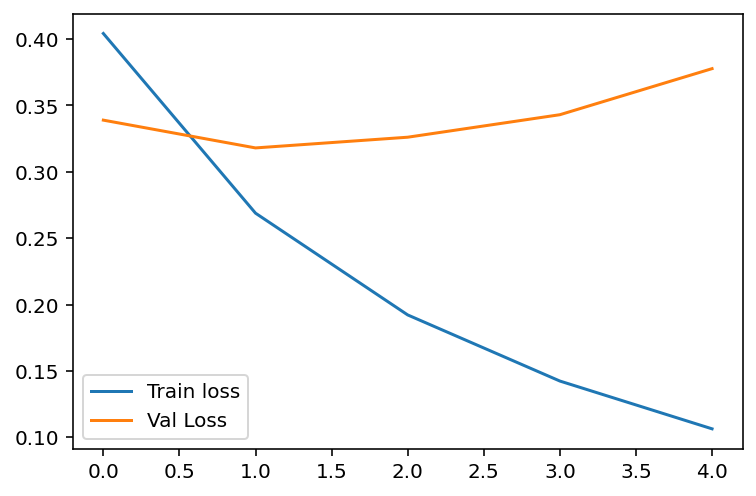

In [39]:
# plot the loss
plt.plot(history_sg.history['loss'], label='Train loss')
plt.plot(history_sg.history['val_loss'], label='Val Loss')
plt.legend();

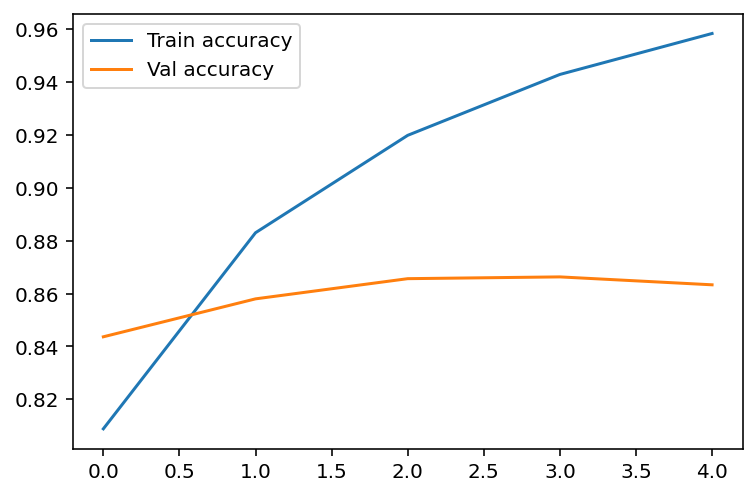

In [40]:
# plot the accuracy
plt.plot(history_sg.history['accuracy'], label='Train accuracy')
plt.plot(history_sg.history['val_accuracy'], label='Val accuracy')
plt.legend();

When the new model is applied on the test data of the tweets retrieved in the odd months in Singapore, the model achieves an accuracy of 86.4%, which is higher than the accuracy score obtained earlier on the Sentiment140 tweets. 

Let's save the model as a separate file that can be used in subsequent notebooks.

In [41]:
# save model to single file
model.save('../models/lstm_sg_odd_wso_model.h5')

With reference to [this notebook](./03-1_preprocessing_and_sentiment_analysis.ipynb), I will use the LSTM RNN model created using predicted labels for Singapore tweets in the odd months of 2021, to predict the sentiment for tweets in the even months of 2021. 